# Example of spectral contrasting

This example demonstrates how to use the contrasting module for finding the frequency bands that provide maximal separation between two timeseries arrays.

#### To open this notebook in collab, right-click the link below and open in a new tab:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/theonlyid/spectral/blob/release/1.1/docs/notebooks/python/example_contrast.ipynb)


In [1]:

# Run this cell if running notebook from Google Colab
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    
    # clone repo from github
    !git clone -b release/1.1 --depth 1 https://github.com/theonlyid/spectral.git

    # install the package
    %cd spectral
    !python setup.py install
    %cd ..

In [2]:
# import depencies
import numpy as np
from spectral.contrast import decimate, contrast, filter
from spectral.data_handling import *

In [3]:
# The dataset is composed of two objects: timeseries and params

# DataArray stores the timeseries array along with its sampling frequency

# The 'simulate()' method simulates timeseries data
# We'll generate two timeseries' and contrast them
ts1 = DataArray.simulate_recording(fs=1000, nchannels=10, ntrials=5, seed=10)
ts2 = DataArray.simulate_recording(fs=1000, nchannels=10, ntrials=5, seed=30)

ts = np.append(ts1, ts2, axis=-1)

da = DataArray(ts, fs=1000)

# TsParams stores the  params for time-frequency analysis
params = TsParams(nperseg=64, noverlap=48)

# A dataset object is a combination of DataArray and TsParams
# This ensures that they are locked together to enable correct processing
ds = Dataset(da, params)

# We're going to decimate our data by a factor of 10
ds.data_array.data = decimate(ds.data_array.data, 10)
ds.data_array.fs = ds.data_array.fs//10

# y stores binary labels of the trials to contrast
y = np.ones((ds.data_array.data.shape[-1]))
y[5:] = 0

# Contrast then returns an SNR matrix with combinations of band_start and band_stop
# This will inform timseries filtering that enables maximal separability between signals
snr, f = contrast(ds, y, fs=100, nperseg=64, noverlap=48)

<ipython-input-4-01aa5f5e089e>:5: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(f, f, np.log(snr));
<ipython-input-4-01aa5f5e089e>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(f, f, np.log(snr));


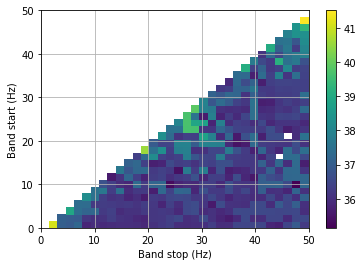

In [4]:
snr[-1,-1] = np.mean(snr.ravel())

# Plot the SNR matrix to visualize results
import matplotlib.pyplot as plt
plt.pcolormesh(f, f, np.log(snr));
plt.xlabel('Band stop (Hz)');
plt.ylabel('Band start (Hz)');
plt.grid();
plt.colorbar();

In [5]:
# Find the frequency range where SNR is highest
idx = np.where(snr==max(snr.ravel()))
start_band, stop_band = np.squeeze(f[idx[0]]), np.squeeze(f[idx[1]])
print(f"optimal band for separating the signals is {start_band:.1f} - {stop_band:.1f} Hz")

optimal band for separating the signals is 46.9 - 48.4 Hz


Text(0, 0.5, 'amplitude')

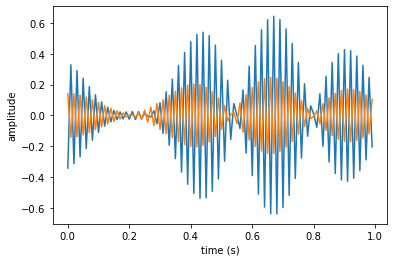

In [6]:
# filter the singal within that range

# first check if band ranges aren't extremums
start_band = 0.1 if start_band == 0 else start_band
stop_band = 49.9 if start_band ==50 else stop_band
filtered_signal = filter(data=ds.data_array.data, low_pass=start_band, high_pass=stop_band, fs=100)

# generate t for plotting
t = np.arange(start=0, stop=filtered_signal.shape[1]/100, step=1/100)
plt.plot(t, filtered_signal[0,:,1]);
plt.plot(t, filtered_signal[0,:,-1]);
plt.xlabel('time (s)')
plt.ylabel('amplitude')